In [1]:
import numpy as np
import numpy.linalg as LA

from scipy import sparse as sp
from scipy import sparse
from scipy.sparse import spdiags
from scipy.sparse import linalg
from scipy.io import savemat,loadmat
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.dpi'] = 150 
from itertools import combinations_with_replacement, product
from tqdm.notebook import trange, tqdm
import sys,time
import os
import copy
import pickle
sys.path.append("..") # Adds higher directory to python modules path.
from LaSDI import LaSDI

In [2]:
# Given parameters
nx = 64
ny = 64
nxy = (ny)*(nx) # 3364
nt = 100
tstop = 1
dt = tstop/nt

In [32]:
training_rad = np.arange(90,130,20) 
training_iv = np.arange(190,230,20)
training_values = list(product(training_rad,training_iv))
nset = len(training_values)
# training_rad = np.arange(80,124,4) 
# training_iv = np.arange(180,224,4)
# training_values = list(product(training_rad,training_iv))
# nset = len(training_values)

In [33]:
nset

4

In [34]:
x = np.linspace(0,1,nx)
y = np.linspace(0,1,ny)
X,Y = np.meshgrid(x,y, indexing = 'xy')

In [6]:
snapshot_matrix = np.empty([nxy, len(training_values)*nt])
for foo, sample in enumerate(training_values):
    ex = np.load('data/ex16_r{}_iv{}.npz'.format(sample[0], sample[1]), allow_pickle = True)
    ex = ex.f.arr_0
    ex = ex.T
    snapshot_matrix[:, nt*foo:nt*(foo+1)] = ex

In [7]:
u,s,vh = LA.svd(snapshot_matrix)
sv_mass = np.cumsum(s)
sv_count = [i for i,ss in enumerate(sv_mass) if ss/sv_mass[-1]>.99][0]+1
s[sv_count:] = 0
print(sv_count, sv_mass[:sv_count]/sv_mass[-1])
phi = u[:,:sv_count]

2 [0.96459033 0.99348022]


In [8]:
latent_space_SS = []
for foo in range(nset):
    latent_space = np.matmul(phi.T, snapshot_matrix[:, nt*foo:nt*(foo+1)])
    latent_space_SS.append(latent_space.T)

In [9]:
degree = 1
normal = 1
# normal = np.amax(np.abs(latent_space_SS))
t = np.linspace(0,tstop,nt)
LaSDI_model = LaSDI(phi.T, phi)

In [10]:
LaSDI_model.train_dynamics(latent_space_SS, training_values, dt)

x0' = 0.266 1 + 0.003 x0 + 0.144 x1
x1' = -7.092 1 + -0.159 x0 + -6.059 x1


In [24]:
FOM = np.load('data/ex16_r{}_iv{}.npz'.format(100,200), allow_pickle = True)
FOM = FOM.f.arr_0
FOM = FOM
time_start = time.time()
FOM_recon = LaSDI_model.generate_FOM(FOM[0], [100,200],t)
LaSDI_time = time.time()-time_start

In [25]:
FOM_re = np.empty(nt)
for j in range(nt):
    FOM_re[j] = LA.norm(FOM_recon[j]-FOM[j])/LA.norm(FOM[j])
max_re = np.amax(FOM_re)*100
speed_up = 4.7/LaSDI_time

Text(0.5, 1.0, 'Absolute Error')

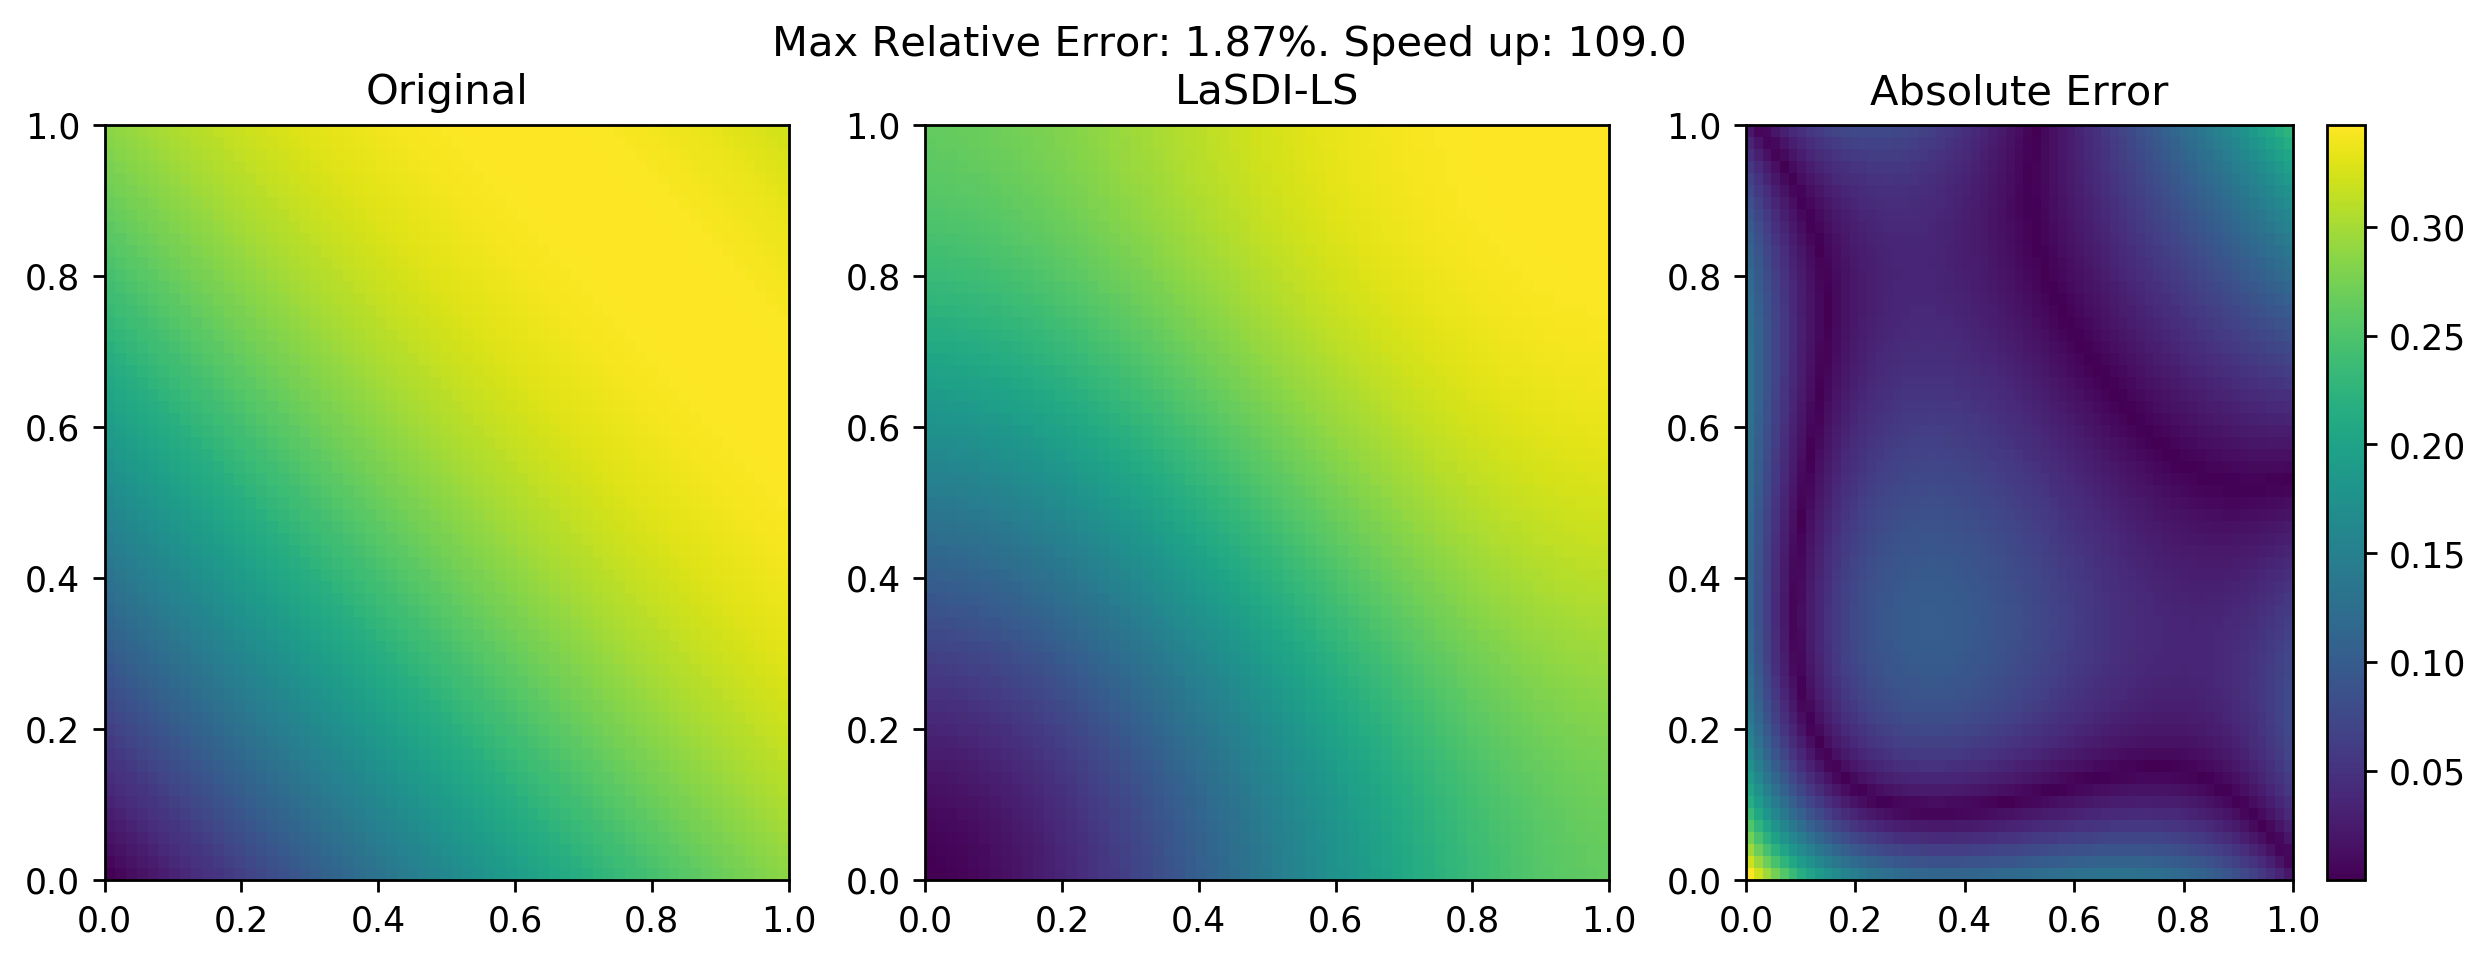

In [27]:
k=0
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
fig.set_size_inches(12,4)
z1=ax1.pcolormesh(X,Y,FOM[k].reshape(nx,ny), shading = 'nearest')
fig.suptitle('Max Relative Error: {:.2f}%. Speed up: {:.1f}'.format(np.amax(max_re), speed_up))
# fig.colorbar(z1, ax = ax1)
# ax1.axis('equal')
ax1.set_title('Original')
z1=ax2.pcolormesh(X,Y,FOM_recon[k].reshape(nx,ny), shading = 'nearest')
# fig.colorbar(z1, ax = ax2)
# ax2.axis('equal')
ax2.set_title('LaSDI-LS')
ax3 = fig.add_subplot(1,3,3)
z1=ax3.pcolormesh(X,Y,np.abs(FOM_recon[k].reshape(nx,ny)-FOM[k].reshape(nx,ny)), shading = 'nearest')
fig.colorbar(z1, ax = ax3)
# ax3.axis('equal')
ax3.set_title('Absolute Error')

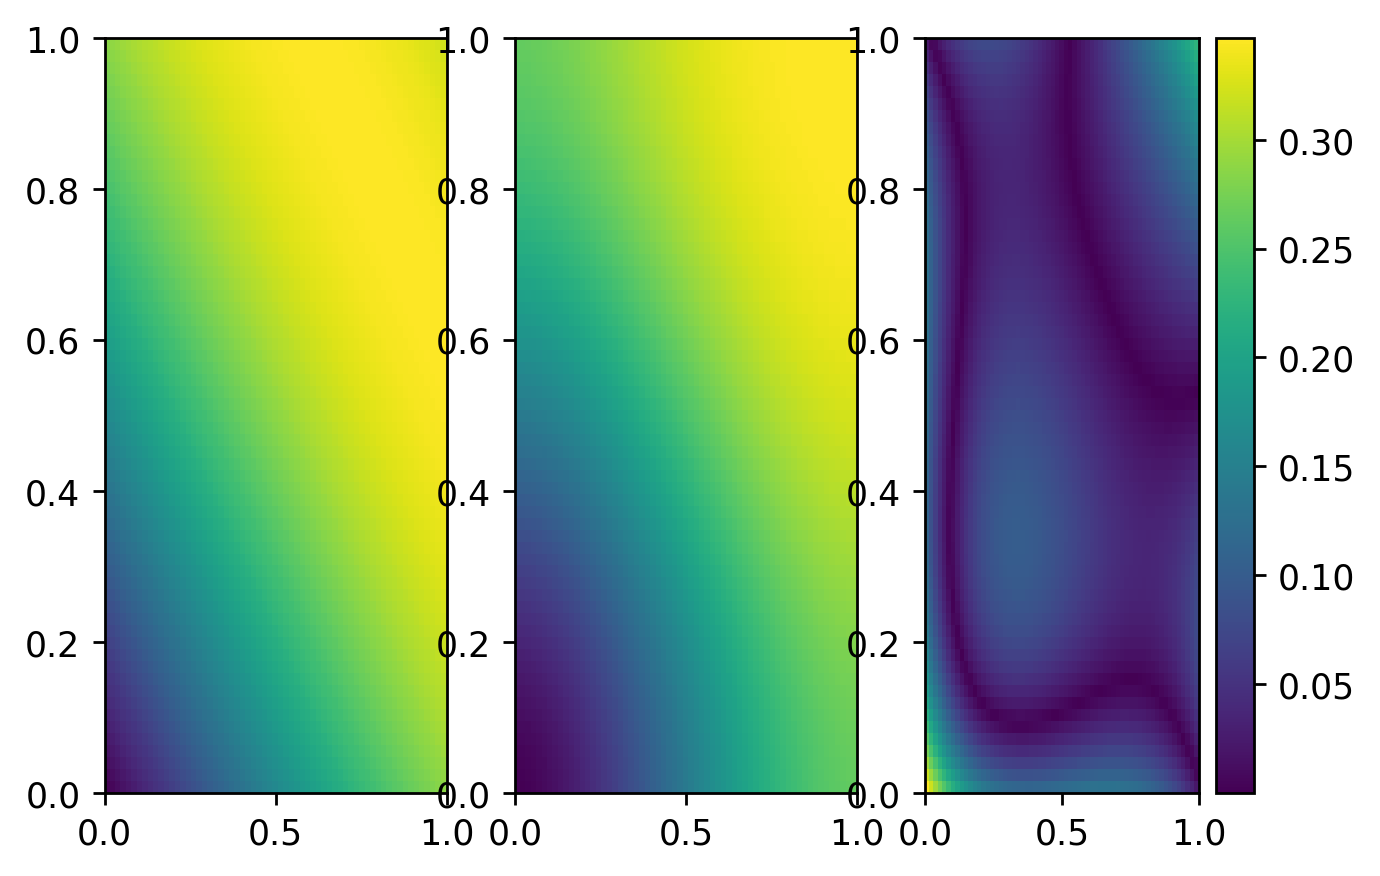

In [15]:
# plt.rcParams['figure.dpi'] = 250
# fig = plt.figure()
# ax1 = fig.add_subplot(1,3,1)
# ax2 = fig.add_subplot(1,3,2)
# ax3 = fig.add_subplot(1,3,3)

# def animate(k):
#     ax1.clear()
#     ax2.clear()
#     ax3.clear()
#     z1=ax1.pcolormesh(X,Y,FOM[k].reshape(nx,ny), shading = 'nearest')
#     # fig.colorbar(z1, ax = ax1)
# #     ax1.axis('equal')
# #     ax1.set_title('Original Final Position')
#     z1=ax2.pcolormesh(X,Y,FOM_recon[k].reshape(nx,ny), shading = 'nearest')
#     # fig.colorbar(z1, ax = ax2)
# #     ax2.axis('equal')
# #     ax2.set_title('ROM Final Position')

#     z1=ax3.pcolormesh(X,Y,np.abs(FOM_recon[k].reshape(nx,ny)-FOM[k].reshape(nx,ny)), shading = 'nearest')
#     fig.colorbar(z1, ax = ax3)
# #     ax3.axis('equal')

# import matplotlib.animation as animation
# anim = animation.FuncAnimation(fig, animate, frames = nt-1, interval = 10)

In [ ]:
# from matplotlib import rc
# rc('animation', html='jshtml')
# anim